# Implementation of Wasserstein GANs
Reference: https://arxiv.org/pdf/1701.07875.pdf

In [ ]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
MODEL_NAME = 'W-GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import h5py

class HDF5DatasetGenerator:
    def __init__(self, dbPath, batchSize):
        self.batchSize = batchSize
        self.db = h5py.File(dbPath,'r')
        self.numParticles = self.db["labels"].shape[0]
        #self.indices = np.arange(self.numParticles)
        #np.random.shuffle(self.indices)
        self.stats = self.db["stats"][:,:]
    def generator(self):
        for i in range(0, self.numParticles-self.batchSize, self.batchSize):
            #ind = sorted(self.indices[i: i + self.batchSize])
            particles = self.db["particles"][i: i + self.batchSize]
            particles = (particles - self.db["stats"][0,:])/self.db["stats"][1,:]
            labels = self.db["labels"][i: i + self.batchSize]
            yield particles[:,[0,1,2,5,6,7]].astype(np.float32)

    def __len__(self):
        return self.numParticles
    def close(self):
        self.db.close()

In [8]:
file = '../data/a1TrainGenerator.hdf5'
# Batch size during training
batch_size = 1024*256

# Number of channels in the training images. For color images this is 3
nc = 6

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 4

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.35

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

generator = HDF5DatasetGenerator(file,batch_size)

In [9]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(nc,64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.LayerNorm(64),
            nn.Sigmoid(),
            nn.Linear(64,64),
            nn.LayerNorm(64),
            nn.Sigmoid(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x: (N, 1, 28, 28), c: (N, 10)
        #x, c = x.view(x.size(0), -1), c.float() # may not need
        #v = torch.cat((x, c), 1) # v: (N, 794)
        #y_ = self.transform(v) # (N, 784)
        #y_ = y_.view(y_.shape[0], 1, 28, 28) # (N, 1, 28, 28)
        #y_ = self.conv(y_)
        #y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(x)
        return y_

In [10]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(nz,32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,nc)
        )
        
    def forward(self, x):
        # x: (N, 100), c: (N, 10)
        #x, c = x.view(x.size(0), -1), c.float() # may not need
        #v = torch.cat((x, c), 1) # v: (N, 110)
        y_ = self.fc(x)
        #y_ = y_.view(y_.size(0), 512, 4, 4)
        #y_ = self.conv(y_) # (N, 28, 28)
        return y_

In [11]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [12]:
D_opt = torch.optim.RMSprop(D.parameters(), lr=0.0005)
G_opt = torch.optim.RMSprop(G.parameters(), lr=0.0005)

In [13]:
step = 0
g_step = 0
n_noise = 100

In [14]:
def n_critic(step, nc=2):
    if step < 25 or step % 500 == 0:
        return 100
    return nc

In [15]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [19]:
for epoch in range(1):
    ds = generator.generator()
    # For each batch in the dataloader
    for step,data_raw in enumerate(ds):
        data = torch.tensor(data_raw)
        # Training Discriminator
        x = data.to(DEVICE)

        x_outputs = D(x)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        # Parameter(Weight) Clipping for K-Lipshitz constraint
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
                    
        if step % 1 == 0:
            g_step += 1
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = -torch.mean(z_outputs)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        if step % 100 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, num_epochs, step, D_loss.item(), G_loss.item()))
        
        if step % 200 == 0:
            G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()


Epoch: 0/4, Step: 0, D Loss: 0.0, G Loss: -0.48892515897750854
Epoch: 0/4, Step: 100, D Loss: 0.0, G Loss: -0.4889218509197235
Epoch: 0/4, Step: 200, D Loss: 0.0, G Loss: -0.488923043012619
Epoch: 0/4, Step: 300, D Loss: 0.0, G Loss: -0.4889020025730133
Epoch: 0/4, Step: 400, D Loss: 0.0, G Loss: -0.48887431621551514
Epoch: 0/4, Step: 500, D Loss: 0.0, G Loss: -0.48863258957862854
Epoch: 0/4, Step: 600, D Loss: 0.0, G Loss: -0.4886528551578522
Epoch: 0/4, Step: 700, D Loss: 0.0, G Loss: -0.4885294437408447
Epoch: 0/4, Step: 800, D Loss: 0.0, G Loss: -0.48856139183044434
Epoch: 0/4, Step: 900, D Loss: -2.9802322387695312e-08, G Loss: -0.48887899518013
Epoch: 0/4, Step: 1000, D Loss: -2.8014183044433594e-06, G Loss: -0.4880901575088501
Epoch: 0/4, Step: 1100, D Loss: 0.0, G Loss: -0.48779207468032837
Epoch: 0/4, Step: 1200, D Loss: 0.0, G Loss: -0.4886261820793152
Epoch: 0/4, Step: 1300, D Loss: 0.0, G Loss: -0.4886496663093567


In [20]:
import matplotlib.pyplot as plt

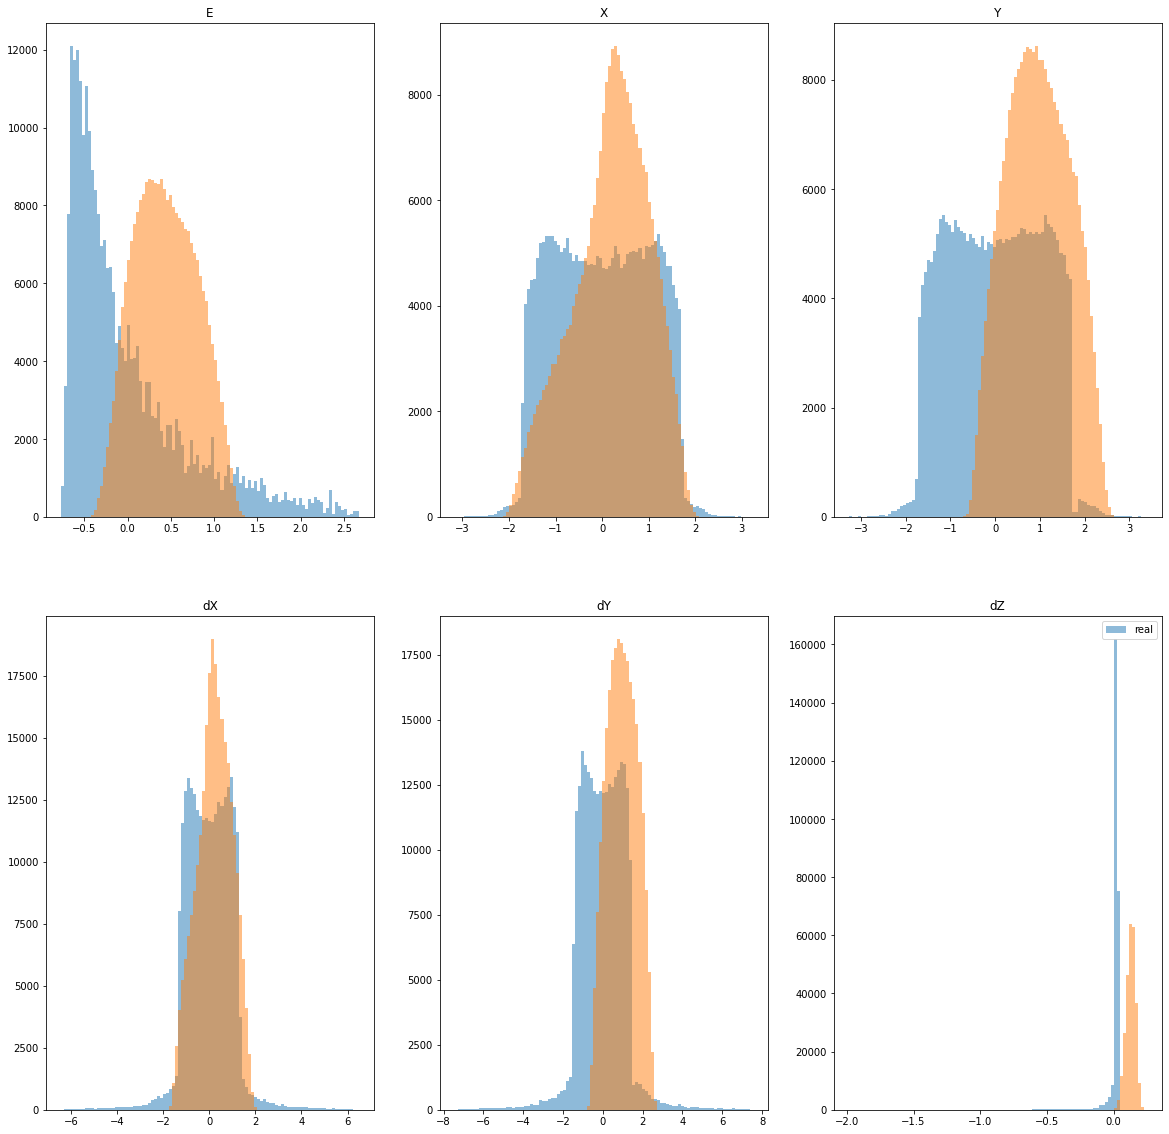

In [21]:
real = next(generator.generator())
keys = ['E','X','Y','dX','dY','dZ']
z = torch.randn(batch_size, n_noise).to(DEVICE)
fake = G(z).to(torch.device("cpu")).detach().numpy()
fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,20)
for i, j in enumerate(keys):
    mi = np.minimum(real[:,i].min(),fake[:,i].min())
    ma = np.maximum(real[:,i].max(),fake[:,i].max())
    bins = np.linspace(mi,ma, 100)
    axs.flatten()[i].hist(real[:,i],bins,alpha=.5)
    axs.flatten()[i].hist(fake[:,i],bins,alpha=.5)
    axs.flatten()[i].set_title(j)
plt.legend(['real'])
plt.show()

Epoch: 0/4, Step: 0, D Loss: 0.0, G Loss: -0.4887506365776062
Epoch: 0/4, Step: 100, D Loss: 0.0, G Loss: -0.4883565306663513
Epoch: 0/4, Step: 200, D Loss: 0.0, G Loss: -0.4914737641811371
Epoch: 0/4, Step: 300, D Loss: -4.172325134277344e-07, G Loss: -0.4878859519958496
Epoch: 0/4, Step: 400, D Loss: 0.0, G Loss: -0.48849183320999146
Epoch: 0/4, Step: 500, D Loss: 0.0, G Loss: -0.4909178614616394
Epoch: 0/4, Step: 600, D Loss: 0.0, G Loss: -0.4917118549346924
Epoch: 0/4, Step: 700, D Loss: 0.0, G Loss: -0.4964151680469513
Epoch: 0/4, Step: 800, D Loss: 0.0, G Loss: -0.4920705556869507
Epoch: 0/4, Step: 900, D Loss: 0.0, G Loss: -0.49301958084106445
Epoch: 0/4, Step: 1000, D Loss: 0.0, G Loss: -0.497065931558609
Epoch: 0/4, Step: 1100, D Loss: 0.0, G Loss: -0.49680665135383606
Epoch: 0/4, Step: 1200, D Loss: 0.0, G Loss: -0.4906240701675415
Epoch: 0/4, Step: 1300, D Loss: 0.0, G Loss: -0.49472659826278687


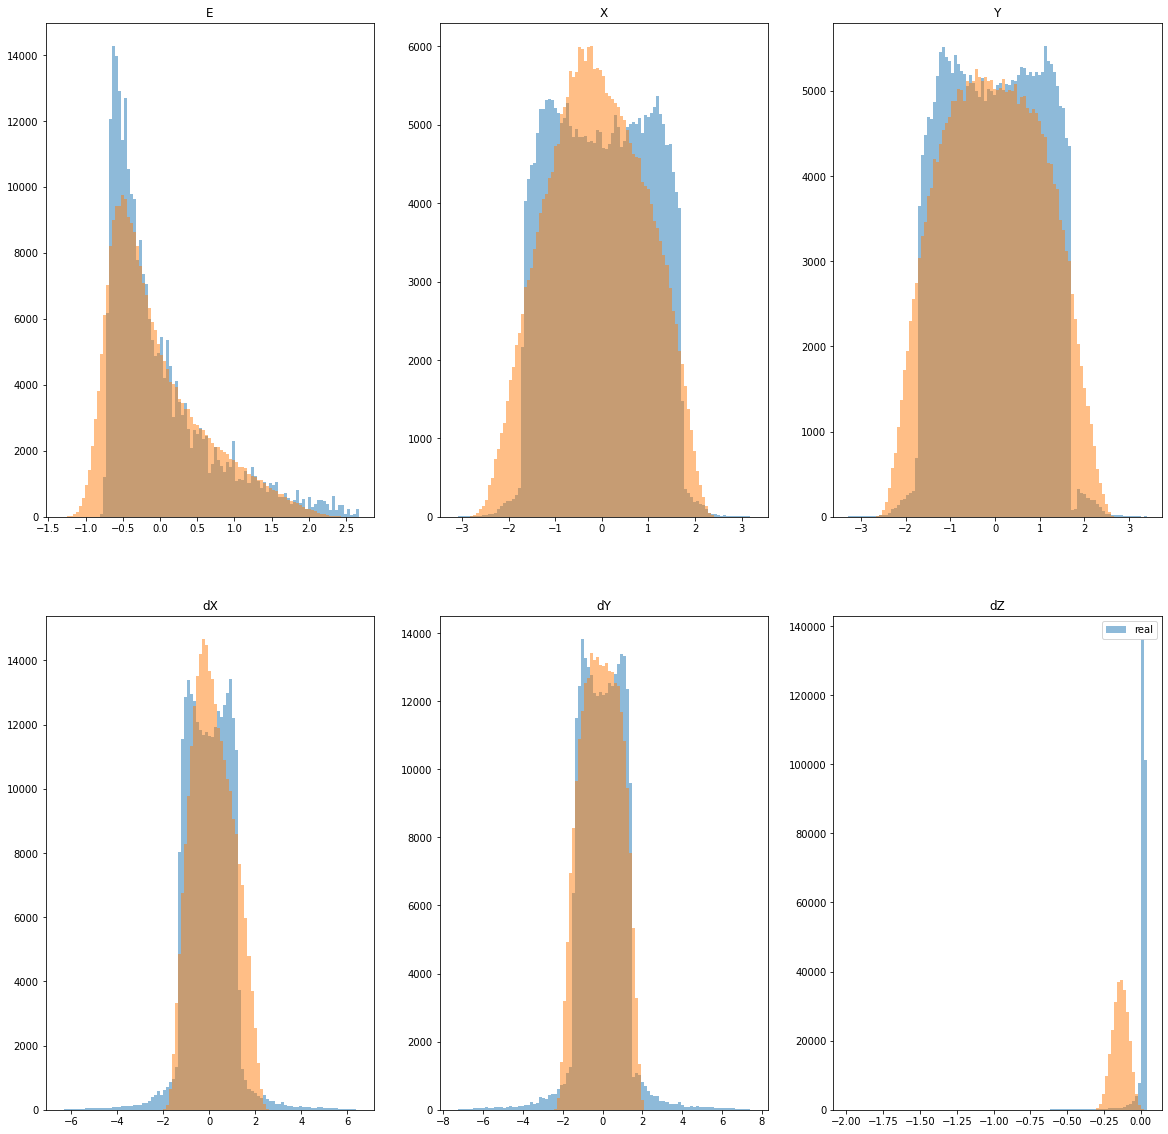

In [22]:
for epoch in range(1):
    ds = generator.generator()
    # For each batch in the dataloader
    for step,data_raw in enumerate(ds):
        data = torch.tensor(data_raw)
        # Training Discriminator
        x = data.to(DEVICE)

        x_outputs = D(x)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        # Parameter(Weight) Clipping for K-Lipshitz constraint
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
                    
        if step % 1 == 0:
            g_step += 1
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = -torch.mean(z_outputs)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        if step % 100 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, num_epochs, step, D_loss.item(), G_loss.item()))
        
        if step % 200 == 0:
            G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()

real = next(generator.generator())
keys = ['E','X','Y','dX','dY','dZ']
z = torch.randn(batch_size, n_noise).to(DEVICE)
fake = G(z).to(torch.device("cpu")).detach().numpy()
fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,20)
for i, j in enumerate(keys):
    mi = np.minimum(real[:,i].min(),fake[:,i].min())
    ma = np.maximum(real[:,i].max(),fake[:,i].max())
    bins = np.linspace(mi,ma, 100)
    axs.flatten()[i].hist(real[:,i],bins,alpha=.5)
    axs.flatten()[i].hist(fake[:,i],bins,alpha=.5)
    axs.flatten()[i].set_title(j)
plt.legend(['real'])
plt.show()

Epoch: 0/4, Step: 0, D Loss: -2.9802322387695312e-08, G Loss: -0.4950938820838928
Epoch: 0/4, Step: 100, D Loss: 0.0, G Loss: -0.4997387230396271
Epoch: 0/4, Step: 200, D Loss: 0.0, G Loss: -0.4996044337749481
Epoch: 0/4, Step: 300, D Loss: 0.0, G Loss: -0.4995828866958618
Epoch: 0/4, Step: 400, D Loss: 0.0, G Loss: -0.49959561228752136
Epoch: 0/4, Step: 500, D Loss: 0.0, G Loss: -0.49965280294418335
Epoch: 0/4, Step: 600, D Loss: 0.0, G Loss: -0.4992155134677887
Epoch: 0/4, Step: 700, D Loss: 0.0, G Loss: -0.49900752305984497
Epoch: 0/4, Step: 800, D Loss: 0.0, G Loss: -0.49898359179496765
Epoch: 0/4, Step: 900, D Loss: 0.0, G Loss: -0.498877614736557
Epoch: 0/4, Step: 1000, D Loss: 0.0, G Loss: -0.49925699830055237
Epoch: 0/4, Step: 1100, D Loss: 0.0, G Loss: -0.49897298216819763
Epoch: 0/4, Step: 1200, D Loss: 0.0, G Loss: -0.49799859523773193
Epoch: 0/4, Step: 1300, D Loss: 0.0, G Loss: -0.49857616424560547


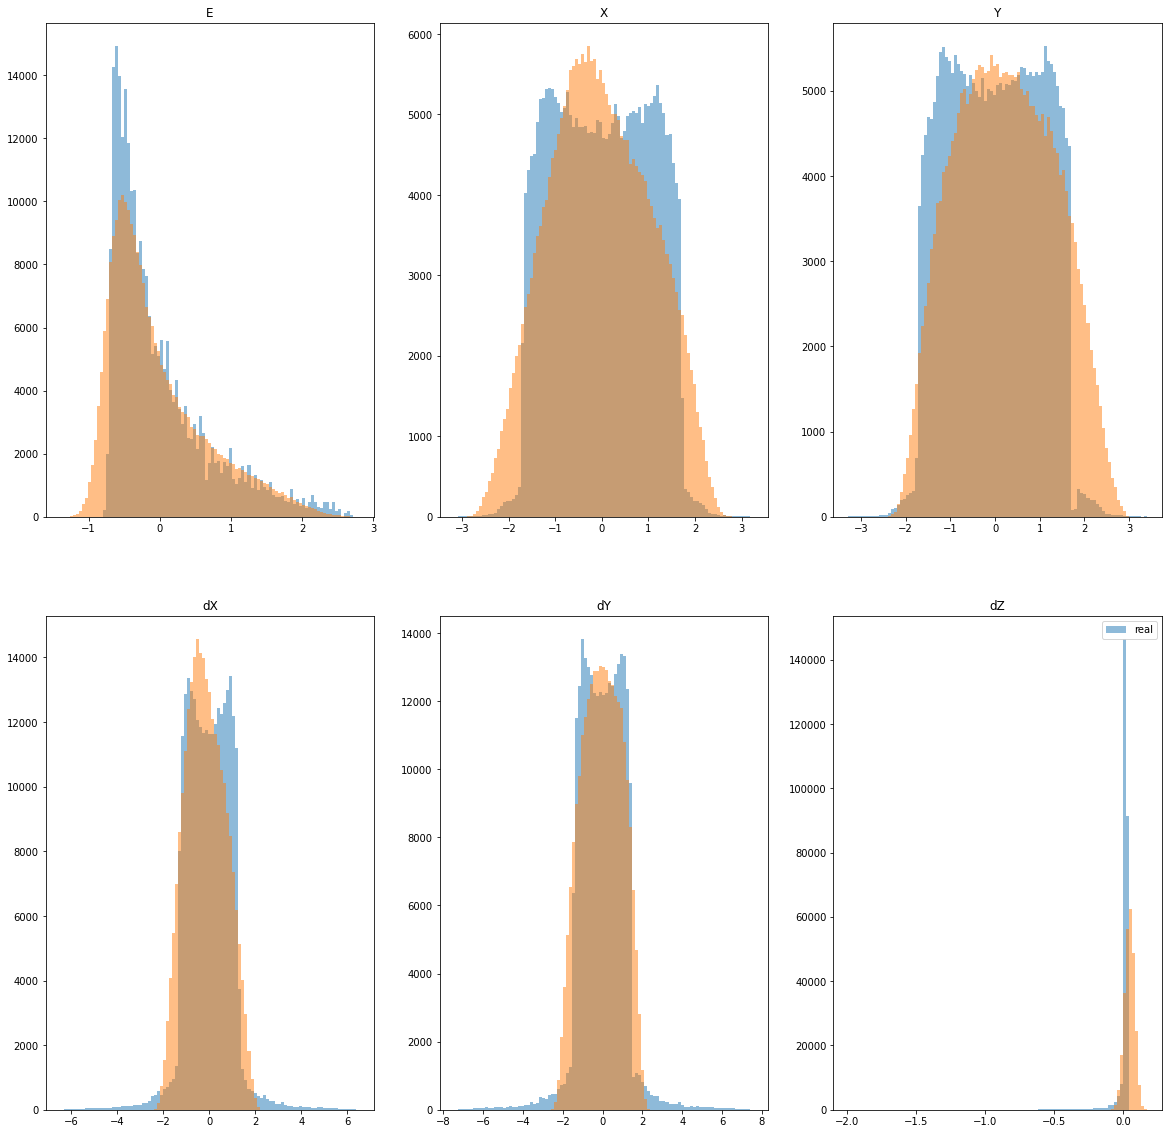

In [23]:
for epoch in range(1):
    ds = generator.generator()
    # For each batch in the dataloader
    for step,data_raw in enumerate(ds):
        data = torch.tensor(data_raw)
        # Training Discriminator
        x = data.to(DEVICE)

        x_outputs = D(x)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        # Parameter(Weight) Clipping for K-Lipshitz constraint
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
                    
        if step % 1 == 0:
            g_step += 1
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = -torch.mean(z_outputs)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        if step % 100 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, num_epochs, step, D_loss.item(), G_loss.item()))
        
        if step % 200 == 0:
            G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()

real = next(generator.generator())
keys = ['E','X','Y','dX','dY','dZ']
z = torch.randn(batch_size, n_noise).to(DEVICE)
fake = G(z).to(torch.device("cpu")).detach().numpy()
fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,20)
for i, j in enumerate(keys):
    mi = np.minimum(real[:,i].min(),fake[:,i].min())
    ma = np.maximum(real[:,i].max(),fake[:,i].max())
    bins = np.linspace(mi,ma, 100)
    axs.flatten()[i].hist(real[:,i],bins,alpha=.5)
    axs.flatten()[i].hist(fake[:,i],bins,alpha=.5)
    axs.flatten()[i].set_title(j)
plt.legend(['real'])
plt.show()

Epoch: 0/4, Step: 0, D Loss: 0.0, G Loss: -0.4926357865333557
Epoch: 0/4, Step: 100, D Loss: -2.086162567138672e-07, G Loss: -0.4885942339897156
Epoch: 0/4, Step: 200, D Loss: 0.0, G Loss: -0.48711708188056946
Epoch: 0/4, Step: 300, D Loss: 0.0, G Loss: -0.49090418219566345
Epoch: 0/4, Step: 400, D Loss: 0.0, G Loss: -0.4914020299911499
Epoch: 0/4, Step: 500, D Loss: 0.0, G Loss: -0.48946765065193176
Epoch: 0/4, Step: 600, D Loss: 0.0, G Loss: -0.48817092180252075
Epoch: 0/4, Step: 700, D Loss: 0.0, G Loss: -0.4956665337085724
Epoch: 0/4, Step: 800, D Loss: 0.0, G Loss: -0.49559953808784485
Epoch: 0/4, Step: 900, D Loss: 0.0, G Loss: -0.49563801288604736
Epoch: 0/4, Step: 1000, D Loss: 0.0, G Loss: -0.4953889846801758
Epoch: 0/4, Step: 1100, D Loss: 0.0, G Loss: -0.49478238821029663
Epoch: 0/4, Step: 1200, D Loss: 0.0, G Loss: -0.49472776055336
Epoch: 0/4, Step: 1300, D Loss: 0.0, G Loss: -0.49309760332107544


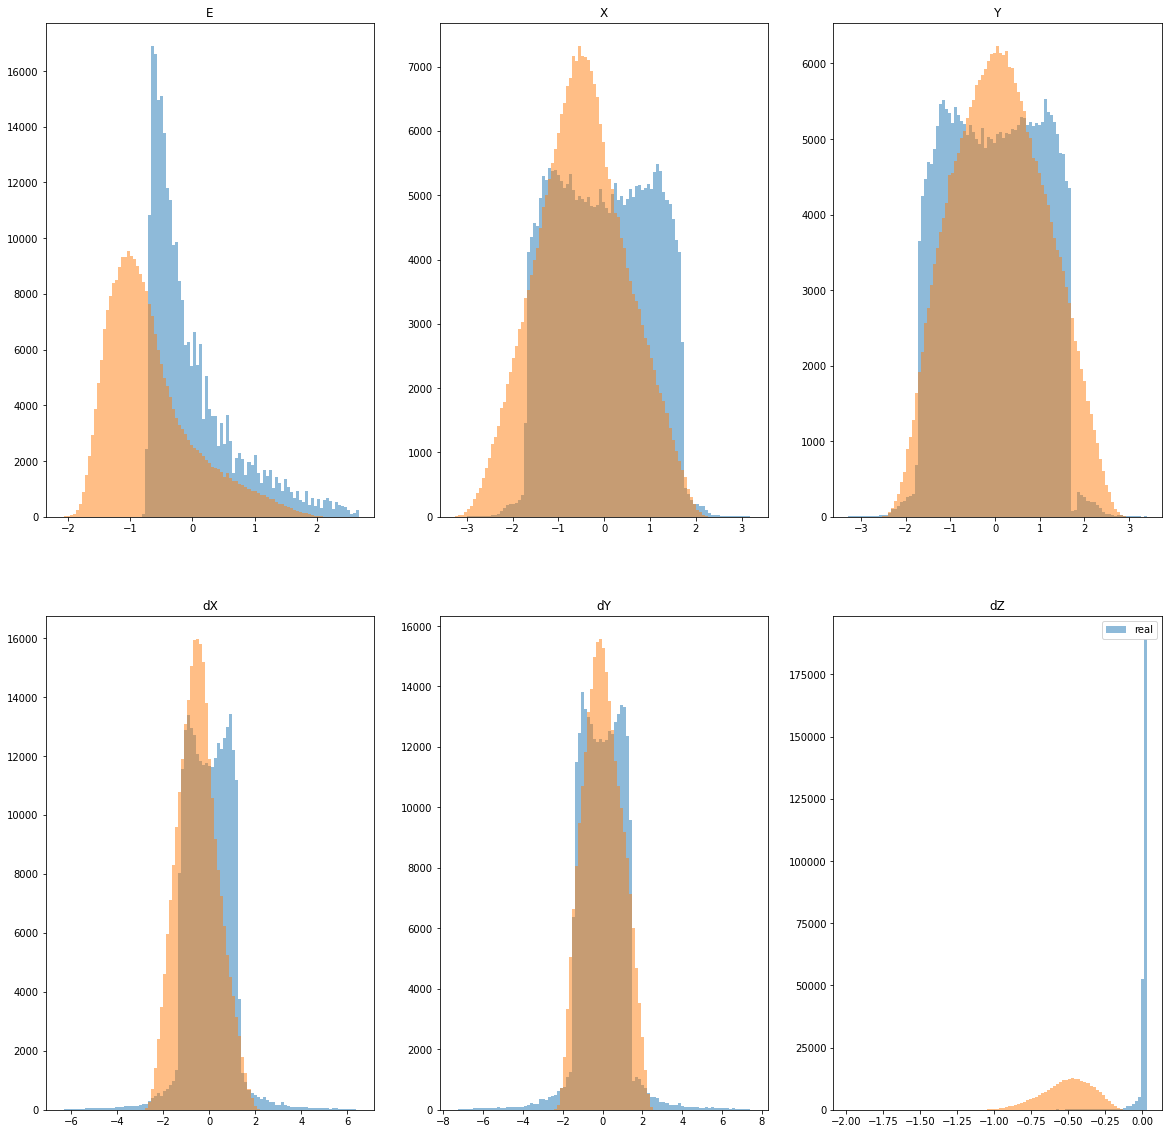

In [24]:
for epoch in range(1):
    ds = generator.generator()
    # For each batch in the dataloader
    for step,data_raw in enumerate(ds):
        data = torch.tensor(data_raw)
        # Training Discriminator
        x = data.to(DEVICE)

        x_outputs = D(x)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        # Parameter(Weight) Clipping for K-Lipshitz constraint
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
                    
        if step % 1 == 0:
            g_step += 1
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = -torch.mean(z_outputs)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
            
        if step % 100 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, num_epochs, step, D_loss.item(), G_loss.item()))
        
        if step % 200 == 0:
            G.eval()
            #img = get_sample_image(G, n_noise)
            #imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()

real = next(generator.generator())
keys = ['E','X','Y','dX','dY','dZ']
z = torch.randn(batch_size, n_noise).to(DEVICE)
fake = G(z).to(torch.device("cpu")).detach().numpy()
fig,axs = plt.subplots(2,3)
fig.set_size_inches(20,20)
for i, j in enumerate(keys):
    mi = np.minimum(real[:,i].min(),fake[:,i].min())
    ma = np.maximum(real[:,i].max(),fake[:,i].max())
    bins = np.linspace(mi,ma, 100)
    axs.flatten()[i].hist(real[:,i],bins,alpha=.5)
    axs.flatten()[i].hist(fake[:,i],bins,alpha=.5)
    axs.flatten()[i].set_title(j)
plt.legend(['real'])
plt.show()

## Sample

In [22]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [24]:
# Saving params.
torch.save(D.state_dict(), 'D_c.pkl')
torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_w.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_w.pth.tar')